In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'

In [4]:
training_subject_start = 0
training_subject_end = 670

In [5]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [6]:
def make_errorbar_two_sides_reuse_axs(axs, xname:str, xvalues:torch.Tensor, yname:str, yvalues:torch.Tensor, y_bounds=None, save:bool=False, file_name:str=None):
    y_middle = yvalues[:,1]
    y_low = y_middle - yvalues[:,0]
    y_high = yvalues[:,2] - y_middle
    y_err = torch.stack( (y_low,y_high), dim=0 )
    axs.errorbar(  x=depytorch(xvalues), y=depytorch(y_middle), yerr=depytorch(y_err), color='red', ecolor='blue'  )
    # axs.plot(x_flat, y_flat, color='red', label='mean', linewidth=10, fillstyle='full')
    if type(y_bounds) != type(None):
        axs.set_ylim(y_bounds)
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    axs.tick_params(axis='y', labelcolor='red')

In [7]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [8]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [23]:
def get_fc_corr_summary_and_update_counts(param_string:str, pre_updates:int, min_updates:int, max_updates:int, update_increment:int):
    fc_corr_file = os.path.join(file_dir, f'summary_fc_corr_{param_string}_updates_min_{min_updates}_max_{max_updates}_increment_{update_increment}.pt')
    fc_corr = torch.load(fc_corr_file)
    print( f'loaded {fc_corr_file}, size', fc_corr.size() )
    update_counts = torch.arange(start=pre_updates+min_updates, end=pre_updates+max_updates+1, step=update_increment, dtype=int_type, device=device)
    return fc_corr, update_counts

In [14]:
def print_fitting_progress(axs, update_counts:torch.Tensor, fc_corr:torch.Tensor, med_color:str, ci_color:str, range_color:str, label:str):
    stat_vals = fc_corr.transpose(dim0=0, dim1=1)
    stat_med = stat_vals[0,:]
    stat_med_2d = stat_med.unsqueeze(dim=0)
    stat_ci = torch.abs(stat_vals[1:3,:] - stat_med)
    stat_range = torch.abs(stat_vals[3:,:] - stat_med)
    axs.errorbar( x=depytorch(update_counts), y=depytorch(stat_med), yerr=depytorch(stat_range), color=range_color )# , label=f'{label} range'
    axs.errorbar( x=depytorch(update_counts), y=depytorch(stat_med), yerr=depytorch(stat_ci), color=ci_color, elinewidth=5, label=f'{label}' )# , label=f'{label} 95% CI'
    # axs.scatter( depytorch(update_counts), depytorch(stat_med), color=med_color )# , label=f'{label} median'

In [10]:
min_updates = 1000
max_updates = 20000
update_increment = 1000
param_string = f'summary_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_updates_min_{min_updates}_max_{max_updates}_increment_{update_increment}'

In [8]:
min_updates = 1000
max_updates = 20000
update_increment = 1000
param_string = f'summary_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_71_individual_updates_updates_min_{min_updates}_max_{max_updates}_increment_{update_increment}'

In [14]:
min_updates = 1000
max_updates = 11000
update_increment = 1000
param_string = f'summary_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_updates_min_{min_updates}_max_{max_updates}_increment_{update_increment}'

In [ ]:
min_updates = 1000
max_updates = 20000
update_increment = 1000
param_string = f'summary_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_updates_min_{min_updates}_max_{max_updates}_increment_{update_increment}'

In [9]:
min_updates = 1000
max_updates = 20000
update_increment = 1000
param_string = f'summary_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_updates_min_{min_updates}_max_{max_updates}_increment_{update_increment}'

In [ ]:
min_updates = 0
max_updates = 53000
update_increment = 1000
# subset = 'training'
subset = 'other'
param_string = f'{subset}_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_updates_min_{min_updates}_max_{max_updates}_increment_{update_increment}'

In [21]:
min_updates = 0
max_updates = 39000
update_increment = 1000
subset = 'training'
# subset = 'other'
param_string = f'{subset}_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_updates_min_{min_updates}_max_{max_updates}_increment_{update_increment}'

In [22]:
fc_corr_file = os.path.join(file_dir, f'summary_fc_corr_{param_string}.pt')
fc_corr = torch.load(fc_corr_file)
print( f'loaded {fc_corr_file}, size', fc_corr.size() )
print(fc_corr)

loaded E:\Ising_model_results_daai\summary_fc_corr_training_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_updates_min_0_max_39000_increment_1000.pt, size torch.Size([40, 5])
tensor([[ 0.4244,  0.1985,  0.5813,  0.0255,  0.6407],
        [ 0.2486,  0.2367,  0.2638,  0.1553,  0.6057],
        [ 0.4573,  0.4438,  0.4775,  0.2893,  0.4897],
        [ 0.1224,  0.0325,  0.7187,  0.0018,  0.8419],
        [ 0.1006,  0.0096,  0.8061, -0.0041,  0.8478],
        [ 0.7530,  0.1497,  0.8505,  0.0929,  0.9141],
        [ 0.8290,  0.3272,  0.8756,  0.1901,  0.9099],
        [ 0.8538,  0.3805,  0.8963,  0.2636,  0.9295],
        [ 0.8745,  0.5036,  0.9107,  0.2855,  0.9413],
        [ 0.8881,  0.5738,  0.9202,  0.4125,  0.9475],
        [ 0.9017,  0.6479,  0.9320,  0.5031,  0.9512],
        [ 0.9141,  0.6992,  0.9410,  0.5350,  0.9640],
        [ 0.9256,  0.7343,  0.9489,  0.6292,  0.9606],
        [ 0.9337,  0.75

In [23]:
# update_counts = torch.cat(  ( torch.arange(start=min_updates, end=35000+1, step=update_increment, dtype=int_type, device=device), torch.arange(start=38000, end=max_updates+1, step=update_increment, dtype=int_type, device=device) ), dim=0  )
update_counts = torch.arange(start=min_updates, end=max_updates+1, step=update_increment, dtype=int_type, device=device)
print( update_counts.size() )

torch.Size([40])


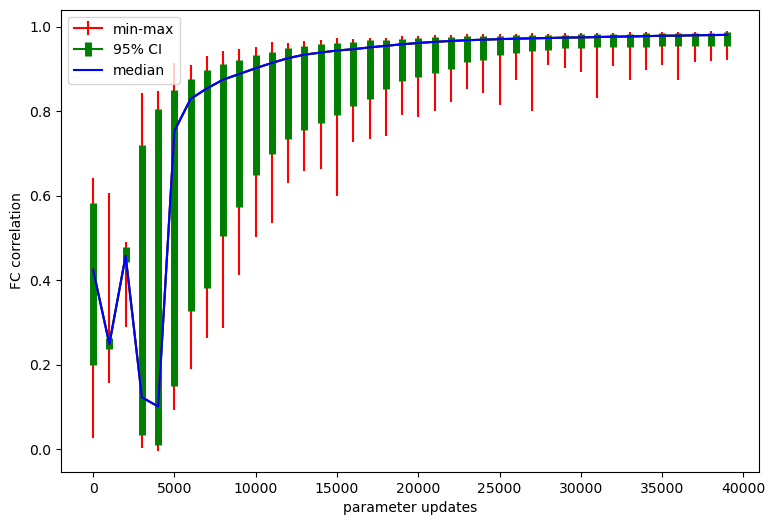

In [24]:
stat_vals = fc_corr.transpose(dim0=0, dim1=1)
stat_name = 'FC correlation'
stat_med = stat_vals[0,:]
stat_med_2d = stat_med.unsqueeze(dim=0)
stat_ci = torch.abs(stat_vals[1:3,:] - stat_med)
stat_min_max = torch.abs(stat_vals[3:,:] - stat_med)
med_color = 'blue'
ci_color = 'green'
min_max_color = 'red'
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.errorbar( x=depytorch(update_counts), y=depytorch(stat_med), yerr=depytorch(stat_min_max), color=min_max_color, label='min-max' )
axs.errorbar( x=depytorch(update_counts), y=depytorch(stat_med), yerr=depytorch(stat_ci), color=ci_color, elinewidth=5, label='95% CI' )
axs.errorbar( depytorch(update_counts), depytorch(stat_med), color=med_color, label='median' )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('parameter updates')
axs.set_ylabel(stat_name)
axs.legend()
# axs.set_xlim([0, 35600])
# axs.set_title(f'{xname} vs {yname}')
plt.show()

In [30]:
min_updates = 0
update_increment = 1000
subset = 'training'
# subset = 'other'

pre_updates = 0
max_updates = 20000
param_string = f'{subset}_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates'
fc_corr_group, update_counts_group = get_fc_corr_summary_and_update_counts(param_string=param_string, pre_updates=pre_updates, min_updates=min_updates, max_updates=max_updates, update_increment=update_increment)

pre_updates = 0
max_updates = 20000
param_string = f'{subset}_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps'
fc_corr_individual, update_counts_individual = get_fc_corr_summary_and_update_counts(param_string=param_string, pre_updates=pre_updates, min_updates=min_updates, max_updates=max_updates, update_increment=update_increment)

pre_updates = 0
max_updates = 20000
param_string = f'{subset}_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_71_individual_updates'
fc_corr_group_0_individual_20k, update_counts_group_0_individual_20k = get_fc_corr_summary_and_update_counts(param_string=param_string, pre_updates=pre_updates, min_updates=min_updates, max_updates=max_updates, update_increment=update_increment)

pre_updates = 10000
max_updates = 10000
param_string = f'{subset}_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates'
fc_corr_group_10k_individual_10k, update_counts_group_10k_individual_10k = get_fc_corr_summary_and_update_counts(param_string=param_string, pre_updates=pre_updates, min_updates=min_updates, max_updates=max_updates, update_increment=update_increment)

loaded E:\Ising_model_results_daai\summary_fc_corr_training_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_updates_min_0_max_20000_increment_1000.pt, size torch.Size([21, 5])
loaded E:\Ising_model_results_daai\summary_fc_corr_training_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_updates_min_0_max_20000_increment_1000.pt, size torch.Size([21, 5])
loaded E:\Ising_model_results_daai\summary_fc_corr_training_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_71_individual_updates_updates_min_0_max_20000_increment_1000.pt, size torch.Size([21, 5])
loaded E:\Ising_model_results_daai\summary_fc_corr_training_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_updates_min_0_max_10000_

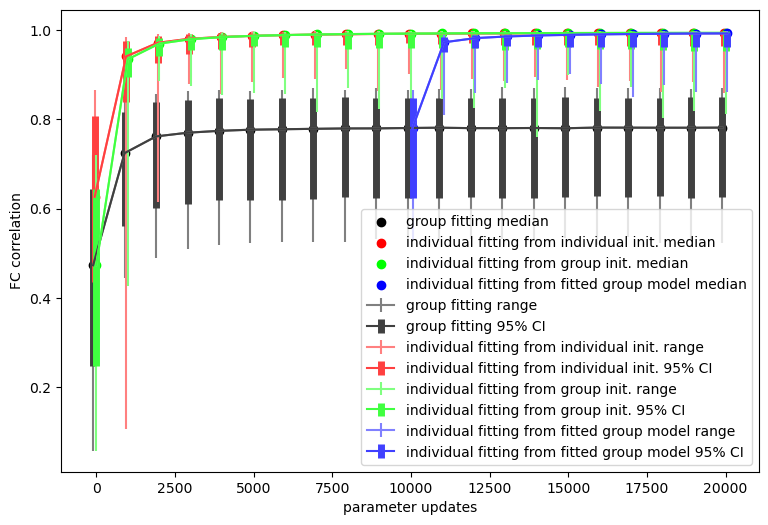

In [32]:
med_color = 'blue'
ci_color = 'green'
min_max_color = 'red'
vis_offset = 50# offset errorbars for visibility
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
print_fitting_progress(axs, update_counts=update_counts_group-2*vis_offset, fc_corr=fc_corr_group, med_color=[0.0, 0.0, 0.0], ci_color=[0.25, 0.25, 0.25], range_color=[0.5, 0.5, 0.5], label='group fitting')
print_fitting_progress(axs, update_counts=update_counts_individual-vis_offset, fc_corr=fc_corr_individual, med_color=[1.0, 0.0, 0.0], ci_color=[1.0, 0.25, 0.25], range_color=[1.0, 0.5, 0.5], label='individual fitting from individual init.')
print_fitting_progress(axs, update_counts=update_counts_group_0_individual_20k, fc_corr=fc_corr_group_0_individual_20k, med_color=[0.0, 1.0, 0.0], ci_color=[0.25, 1.0, 0.25], range_color=[0.5, 1.0, 0.5], label='individual fitting from group init.')
print_fitting_progress(axs, update_counts=update_counts_group_10k_individual_10k+vis_offset, fc_corr=fc_corr_group_10k_individual_10k, med_color=[0.0, 0.0, 1.0], ci_color=[0.25, 0.25, 1.0], range_color=[0.5, 0.5, 1.0], label='individual fitting from fitted group model')
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('parameter updates')
axs.set_ylabel('FC correlation')
axs.legend(loc='lower right')
# axs.set_ylim([0.8, 1.0])
# axs.set_title(f'{xname} vs {yname}')
plt.show()

In [26]:
print( fc_corr_group[0,:] )
print( fc_corr_group_0_individual_20k[0,:] )

tensor([0.4730, 0.2462, 0.6444, 0.0572, 0.7207], device='cuda:0')
tensor([0.4671, 0.2750, 0.6329, 0.1653, 0.6871], device='cuda:0')


In [24]:
fc_corr_individual_last_file = os.path.join(file_dir, f'fc_corr_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_20000_test_length_120000.pt')
fc_corr_individual_last = torch.load(fc_corr_individual_last_file)
print( f'loaded {fc_corr_individual_last_file}', fc_corr_individual_last.size() )

loaded E:\Ising_model_results_daai\fc_corr_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_20000_test_length_120000.pt torch.Size([5, 837])


In [25]:
fc_corr_group_0_individual_20k_last_file = os.path.join(file_dir, f'fc_corr_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_71_individual_updates_20000_test_length_120000.pt')
fc_corr_group_0_individual_20k_last = torch.load(fc_corr_group_0_individual_20k_last_file)
print( f'loaded {fc_corr_group_0_individual_20k_last_file}', fc_corr_group_0_individual_20k_last.size() )

loaded E:\Ising_model_results_daai\fc_corr_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_71_individual_updates_20000_test_length_120000.pt torch.Size([5, 837])


In [26]:
fc_corr_group_10k_individual_10k_last_file = os.path.join(file_dir, f'fc_corr_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_test_length_120000.pt')
fc_corr_group_10k_individual_10k_last = torch.load(fc_corr_group_10k_individual_10k_last_file)
print( f'loaded {fc_corr_group_10k_individual_10k_last_file}', fc_corr_group_10k_individual_10k_last.size() )

loaded E:\Ising_model_results_daai\fc_corr_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_test_length_120000.pt torch.Size([5, 837])


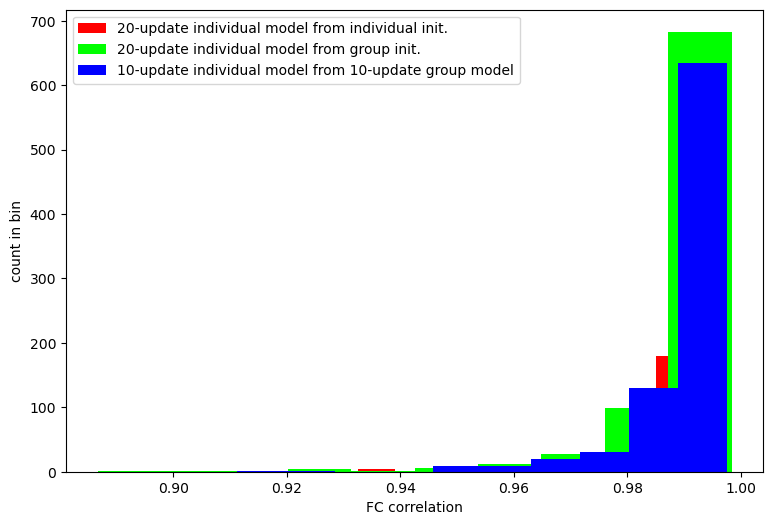

In [57]:
# subset = 'training'
# index_start = training_subject_start
# index_end = training_subject_end
subset = 'other'
index_start = training_subject_end
index_end = fc_corr_individual_last.size(dim=1)
fc_corr_individual_last_subset = fc_corr_individual_last[:,index_start:index_end].flatten()
fc_corr_individual_last_subset_np = depytorch(fc_corr_individual_last_subset)
fc_corr_group_0_individual_20k_last_subset = fc_corr_group_0_individual_20k_last[:,index_start:index_end].flatten()
fc_corr_group_0_individual_20k_last_subset_np = depytorch(fc_corr_group_0_individual_20k_last_subset)
fc_corr_group_10k_individual_10k_last_subset = fc_corr_group_10k_individual_10k_last[:,index_start:index_end].flatten()
fc_corr_group_10k_individual_10k_last_subset_np = depytorch(fc_corr_group_10k_individual_10k_last_subset)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.hist(  fc_corr_individual_last_subset_np, color=[1.0, 0.0, 0.0], label='20-update individual model from individual init.'  )
axs.hist(  fc_corr_group_0_individual_20k_last_subset_np, color=[0.0, 1.0, 0.0], label='20-update individual model from group init.'  )
axs.hist(  fc_corr_group_10k_individual_10k_last_subset_np, color=[0.0, 0.0, 1.0], label='10-update individual model from 10-update group model'  )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('FC correlation')
axs.set_ylabel(f'count in bin')
axs.legend()
plt.show()

In [58]:
print_stats(name='FC correlation of individual model', values=fc_corr_individual_last_subset)

The distribution of FC correlation of individual model values has median 0.993 with 95% CI [0.968, 0.998] and range [0.933, 0.998].


In [59]:
print_stats(name='FC correlation of group-initialized individual model', values=fc_corr_group_0_individual_20k_last_subset)

The distribution of FC correlation of group-initialized individual model values has median 0.994 with 95% CI [0.961, 0.998] and range [0.887, 0.998].


In [60]:
print_stats(name='FC correlation of model individualized from fitted group model', values=fc_corr_group_10k_individual_10k_last_subset)

The distribution of FC correlation of model individualized from fitted group model values has median 0.993 with 95% CI [0.964, 0.996] and range [0.911, 0.997].


In [61]:
print(   'individual init vs group init', stats.mannwhitneyu(  x=fc_corr_individual_last_subset_np, y=fc_corr_group_0_individual_20k_last_subset_np  )   )

individual init vs group init MannwhitneyuResult(statistic=330558.0, pvalue=0.06691127234640203)


In [62]:
print(   'individual model vs individualized-from-group model', stats.mannwhitneyu(  x=fc_corr_individual_last_subset_np, y=fc_corr_group_10k_individual_10k_last_subset_np  )   )

individual model vs individualized-from-group model MannwhitneyuResult(statistic=403985.0, pvalue=1.9138960151605806e-08)


In [63]:
fc_corr_individual_last_subset_mean_np = depytorch( fc_corr_individual_last[:,index_start:index_end].mean(dim=0) )
fc_corr_group_0_individual_20k_last_subset_mean_np = depytorch( fc_corr_group_0_individual_20k_last[:,index_start:index_end].mean(dim=0) )
fc_corr_group_10k_individual_10k_last_subset_mean_np = depytorch( fc_corr_group_10k_individual_10k_last[:,index_start:index_end].mean(dim=0) )

In [64]:
print(   'individual init vs group init', stats.wilcoxon(  x=fc_corr_individual_last_subset_mean_np, y=fc_corr_group_0_individual_20k_last_subset_mean_np  )   )

individual init vs group init WilcoxonResult(statistic=6730.0, pvalue=0.649954589254665)


In [65]:
print(   'individual model vs individualized-from-group model', stats.wilcoxon(  x=fc_corr_individual_last_subset_mean_np, y=fc_corr_group_10k_individual_10k_last_subset_mean_np  )   )

individual model vs individualized-from-group model WilcoxonResult(statistic=5772.0, pvalue=0.04717935096414043)


In [66]:
fc_corr_mean_diff_np = fc_corr_individual_last_subset_mean_np - fc_corr_group_10k_individual_10k_last_subset_mean_np
is_better_from_scratch = fc_corr_mean_diff_np > 0
num_from_scratch_better = np.count_nonzero(is_better_from_scratch)
num_subset_subjects = fc_corr_mean_diff_np.size
print( f'{num_from_scratch_better} out of {num_subset_subjects} subjects ({num_from_scratch_better/num_subset_subjects:.3g}) have a better fit when fitted from scratch.' )
fc_corr_max_diff = fc_corr_mean_diff_np.max()
print( f'The maximum such difference is {fc_corr_max_diff:.3g}.' )

88 out of 167 subjects (0.527) have a better fit when fitted from scratch.
The maximum such difference is 0.0164.


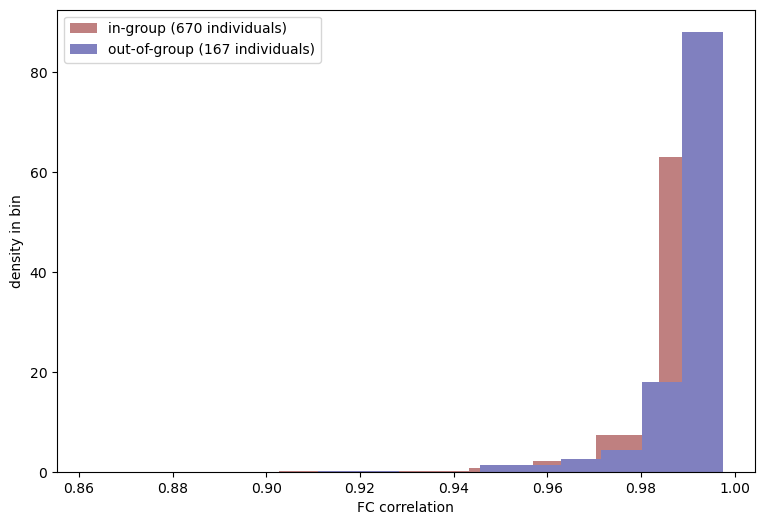

In [97]:
fc_corr_last = fc_corr_group_10k_individual_10k_last
fc_corr_in_group = fc_corr_last[:,training_subject_start:training_subject_end].flatten()
fc_corr_in_group_np = depytorch(fc_corr_in_group)
fc_corr_out_group = fc_corr_last[:,training_subject_end:].flatten()
fc_corr_out_group_np = depytorch(fc_corr_out_group)
num_in_group = training_subject_end - training_subject_start
num_out_group = fc_corr_last.size(dim=1) - training_subject_end
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.hist(  fc_corr_in_group_np, color=[0.75, 0.5, 0.5], label=f'in-group ({num_in_group} individuals)', density=True  )
axs.hist(  fc_corr_out_group_np, color=[0.5, 0.5, 0.75], label=f'out-of-group ({num_out_group} individuals)', density=True  )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('FC correlation')
axs.set_ylabel('density in bin')
axs.legend()
plt.show()

In [98]:
print(   'in-group vs out-group for models individualized from group', stats.mannwhitneyu(  x=fc_corr_in_group_np, y=fc_corr_out_group_np  )   )

in-group vs out-group for models individualized from group MannwhitneyuResult(statistic=1392070.0, pvalue=0.8338013540117045)


In [24]:
min_updates = 0
update_increment = 1000
# subset = 'training'
subset = 'other'

pre_updates = 0
max_updates = 40000
param_string = f'{subset}_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates'
fc_corr_group, update_counts_group = get_fc_corr_summary_and_update_counts(param_string=param_string, pre_updates=pre_updates, min_updates=min_updates, max_updates=max_updates, update_increment=update_increment)

pre_updates = 0
max_updates = 40000
param_string = f'{subset}_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps'
fc_corr_individual, update_counts_individual = get_fc_corr_summary_and_update_counts(param_string=param_string, pre_updates=pre_updates, min_updates=min_updates, max_updates=max_updates, update_increment=update_increment)

pre_updates = 0
max_updates = 40000
param_string = f'{subset}_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_66_individual_updates'
fc_corr_group_0_individual, update_counts_group_0_individual = get_fc_corr_summary_and_update_counts(param_string=param_string, pre_updates=pre_updates, min_updates=min_updates, max_updates=max_updates, update_increment=update_increment)

pre_updates = 10000
max_updates = 30000
param_string = f'{subset}_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_{pre_updates}_individual_updates'
fc_corr_group_10k_individual, update_counts_group_10k_individual = get_fc_corr_summary_and_update_counts(param_string=param_string, pre_updates=pre_updates, min_updates=min_updates, max_updates=max_updates, update_increment=update_increment)

pre_updates = 30000
max_updates = 10000
param_string = f'{subset}_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_{pre_updates}_individual_updates'
fc_corr_group_30k_individual, update_counts_group_30k_individual = get_fc_corr_summary_and_update_counts(param_string=param_string, pre_updates=pre_updates, min_updates=min_updates, max_updates=max_updates, update_increment=update_increment)

loaded E:\Ising_model_results_daai\summary_fc_corr_other_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_updates_min_0_max_40000_increment_1000.pt, size torch.Size([41, 5])
loaded E:\Ising_model_results_daai\summary_fc_corr_other_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_updates_min_0_max_40000_increment_1000.pt, size torch.Size([41, 5])
loaded E:\Ising_model_results_daai\summary_fc_corr_other_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_66_individual_updates_updates_min_0_max_40000_increment_1000.pt, size torch.Size([41, 5])
loaded E:\Ising_model_results_daai\summary_fc_corr_other_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_updates_min_0_max_30000_increment_10

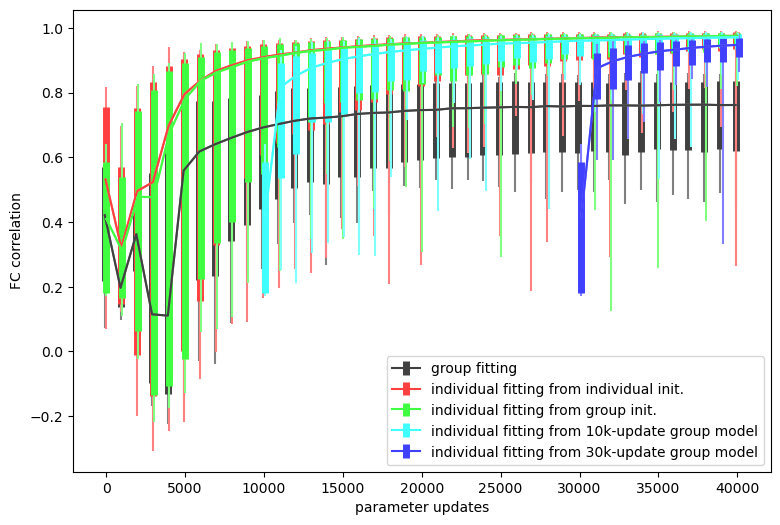

In [25]:
vis_offset = 50# offset errorbars for visibility
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
print_fitting_progress(axs, update_counts=update_counts_group-2*vis_offset, fc_corr=fc_corr_group, med_color=[0.0, 0.0, 0.0], ci_color=[0.25, 0.25, 0.25], range_color=[0.5, 0.5, 0.5], label='group fitting')
print_fitting_progress(axs, update_counts=update_counts_individual-vis_offset, fc_corr=fc_corr_individual, med_color=[1.0, 0.0, 0.0], ci_color=[1.0, 0.25, 0.25], range_color=[1.0, 0.5, 0.5], label='individual fitting from individual init.')
print_fitting_progress(axs, update_counts=update_counts_group_0_individual, fc_corr=fc_corr_group_0_individual, med_color=[0.0, 1.0, 0.0], ci_color=[0.25, 1.0, 0.25], range_color=[0.5, 1.0, 0.5], label='individual fitting from group init.')
print_fitting_progress(axs, update_counts=update_counts_group_10k_individual+vis_offset, fc_corr=fc_corr_group_10k_individual, med_color=[0.0, 1.0, 1.0], ci_color=[0.25, 1.0, 1.0], range_color=[0.5, 1.0, 1.0], label='individual fitting from 10k-update group model')
print_fitting_progress(axs, update_counts=update_counts_group_30k_individual+2*vis_offset, fc_corr=fc_corr_group_30k_individual, med_color=[0.0, 0.0, 1.0], ci_color=[0.25, 0.25, 1.0], range_color=[0.5, 0.5, 1.0], label='individual fitting from 30k-update group model')
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('parameter updates')
axs.set_ylabel('FC correlation')
axs.legend(loc='lower right')
# axs.set_ylim([0.8, 1.0])
# axs.set_title(f'{xname} vs {yname}')
plt.show()

In [13]:
min_updates = 0
update_increment = 1000
subset = 'training'
# subset = 'other'

# pre_updates = 0
# max_updates = 20000
# param_string = f'{subset}_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates'
# fc_corr_group, update_counts_group = get_fc_corr_summary_and_update_counts(param_string=param_string, pre_updates=pre_updates, min_updates=min_updates, max_updates=max_updates, update_increment=update_increment)

pre_updates = 0
max_updates = 45000
param_string = f'{subset}_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps'
fc_corr_individual, update_counts_individual = get_fc_corr_summary_and_update_counts(param_string=param_string, pre_updates=pre_updates, min_updates=min_updates, max_updates=max_updates, update_increment=update_increment)

# pre_updates = 0
# max_updates = 20000
# param_string = f'{subset}_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_71_individual_updates'
# fc_corr_group_0_individual_20k, update_counts_group_0_individual_20k = get_fc_corr_summary_and_update_counts(param_string=param_string, pre_updates=pre_updates, min_updates=min_updates, max_updates=max_updates, update_increment=update_increment)

# pre_updates = 10000
# max_updates = 10000
# param_string = f'{subset}_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates'
# fc_corr_group_10k_individual_10k, update_counts_group_10k_individual_10k = get_fc_corr_summary_and_update_counts(param_string=param_string, pre_updates=pre_updates, min_updates=min_updates, max_updates=max_updates, update_increment=update_increment)

loaded E:\Ising_model_results_daai\summary_fc_corr_training_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_updates_min_0_max_45000_increment_1000.pt, size torch.Size([46, 5])


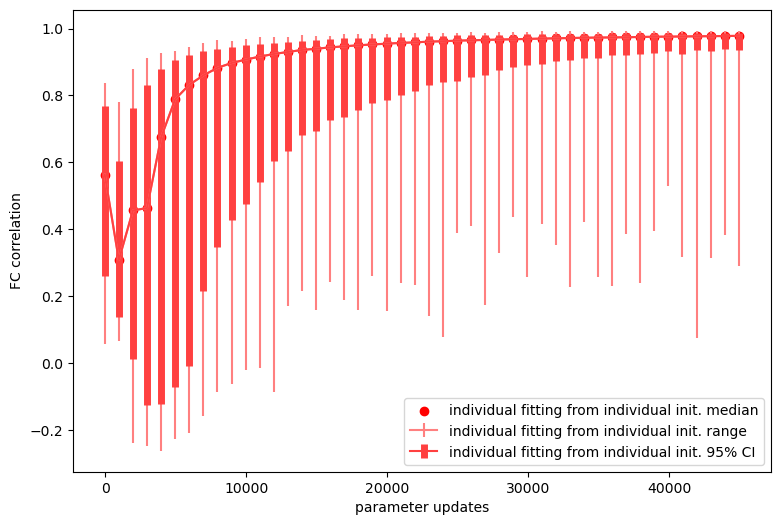

In [14]:
med_color = 'blue'
ci_color = 'green'
min_max_color = 'red'
vis_offset = 50# offset errorbars for visibility
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
# print_fitting_progress(axs, update_counts=update_counts_group-2*vis_offset, fc_corr=fc_corr_group, med_color=[0.0, 0.0, 0.0], ci_color=[0.25, 0.25, 0.25], range_color=[0.5, 0.5, 0.5], label='group fitting')
print_fitting_progress(axs, update_counts=update_counts_individual-vis_offset, fc_corr=fc_corr_individual, med_color=[1.0, 0.0, 0.0], ci_color=[1.0, 0.25, 0.25], range_color=[1.0, 0.5, 0.5], label='individual fitting from individual init.')
# print_fitting_progress(axs, update_counts=update_counts_group_0_individual_20k, fc_corr=fc_corr_group_0_individual_20k, med_color=[0.0, 1.0, 0.0], ci_color=[0.25, 1.0, 0.25], range_color=[0.5, 1.0, 0.5], label='individual fitting from group init.')
# print_fitting_progress(axs, update_counts=update_counts_group_10k_individual_10k+vis_offset, fc_corr=fc_corr_group_10k_individual_10k, med_color=[0.0, 0.0, 1.0], ci_color=[0.25, 0.25, 1.0], range_color=[0.5, 0.5, 1.0], label='individual fitting from fitted group model')
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('parameter updates')
axs.set_ylabel('FC correlation')
axs.legend(loc='lower right')
# axs.set_ylim([0.8, 1.0])
# axs.set_title(f'{xname} vs {yname}')
plt.show()

In [16]:
print( fc_corr_individual[:10,:] )
print( fc_corr_individual[-10:,:] )

tensor([[ 0.5639,  0.2621,  0.7698,  0.0572,  0.8378],
        [ 0.3084,  0.1387,  0.6047,  0.0676,  0.7802],
        [ 0.4566,  0.0119,  0.7634, -0.2387,  0.8802],
        [ 0.4637, -0.1252,  0.8303, -0.2465,  0.9109],
        [ 0.6746, -0.1216,  0.8792, -0.2611,  0.9282],
        [ 0.7888, -0.0709,  0.9050, -0.2274,  0.9327],
        [ 0.8319, -0.0074,  0.9207, -0.2076,  0.9435],
        [ 0.8600,  0.2173,  0.9326, -0.1579,  0.9580],
        [ 0.8825,  0.3466,  0.9383, -0.0848,  0.9654],
        [ 0.8969,  0.4291,  0.9451, -0.0633,  0.9632]], device='cuda:0')
tensor([[0.9733, 0.9217, 0.9853, 0.2298, 0.9924],
        [0.9739, 0.9214, 0.9854, 0.3869, 0.9912],
        [0.9747, 0.9228, 0.9858, 0.2387, 0.9919],
        [0.9754, 0.9277, 0.9863, 0.3942, 0.9915],
        [0.9757, 0.9322, 0.9863, 0.5283, 0.9922],
        [0.9762, 0.9234, 0.9863, 0.3187, 0.9919],
        [0.9768, 0.9347, 0.9868, 0.0743, 0.9934],
        [0.9771, 0.9322, 0.9869, 0.3134, 0.9923],
        [0.9776, 0.9374, 0.9874,

In [9]:
fc_corr_test = torch.load( os.path.join(file_dir, 'fc_corr_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_1000_test_length_120000.pt') )
print( fc_corr_test.size() )

torch.Size([5, 837])


In [9]:
min_updates = 0
max_updates = 40000
update_increment = 1000
num_thresholds = 31
min_threshold = 0
max_threshold = 3
stat_name = 'fc_corr'
stat_name_label = 'FC correlation'
param_string = f'summary_{stat_name}_all_ising_model_light_group_thresholds_{num_thresholds}_min_{min_threshold}_max_{max_threshold}_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_updates_min_{min_updates}_max_{max_updates}_increment_{update_increment}'

In [10]:
stat_values = torch.load( os.path.join(file_dir, f'{param_string}.pt') )
print( stat_values.size() )

torch.Size([41, 31, 5])


In [20]:
stat_values[stat_values < -1] = 0

In [11]:
thresholds = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=stat_values.dtype, device=stat_values.device)
print(thresholds)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000], device='cuda:0')


In [12]:
update_counts = torch.arange(start=min_updates, end=max_updates+1, step=update_increment, dtype=stat_values.dtype, device=stat_values.device)
print(update_counts)

tensor([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,  8000.,
         9000., 10000., 11000., 12000., 13000., 14000., 15000., 16000., 17000.,
        18000., 19000., 20000., 21000., 22000., 23000., 24000., 25000., 26000.,
        27000., 28000., 29000., 30000., 31000., 32000., 33000., 34000., 35000.,
        36000., 37000., 38000., 39000., 40000.], device='cuda:0')


selected thresholds tensor([0.0000, 0.5000, 1.0000, 1.5000, 2.0000, 2.4000], device='cuda:0')
indices tensor([ 0,  5, 10, 15, 20, 24], device='cuda:0')
diffs tensor([0., 0., 0., 0., 0., 0.], device='cuda:0')
actual thresholds tensor([0.0000, 0.5000, 1.0000, 1.5000, 2.0000, 2.4000], device='cuda:0')


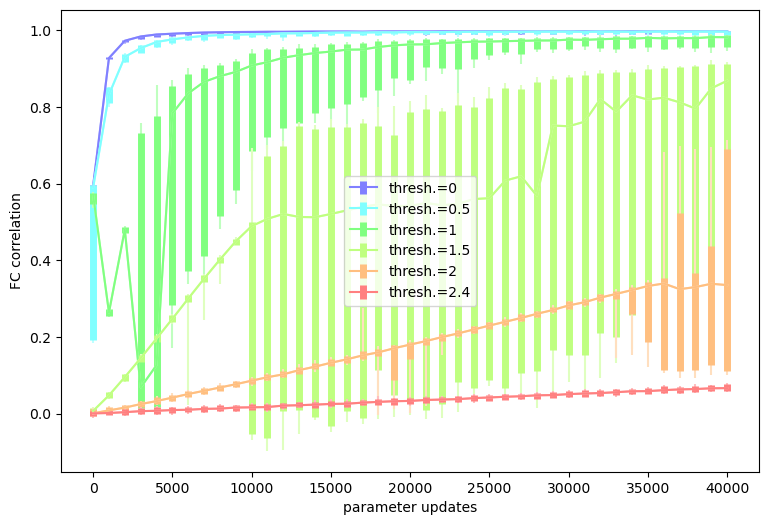

In [15]:
select_colors = [[0.0, 0.0, 1.0], [0.0, 1.0, 1.0], [0.0, 1.0, 0.0], [0.5, 1.0, 0.0], [1.0, 0.5, 0.0], [1.0, 0.0, 0.0]]
select_thresholds = torch.tensor(data=[0.0, 0.5, 1.0, 1.5, 2.0, 2.4], dtype=float_type, device=stat_values.device)
print( 'selected thresholds', select_thresholds )
diff_min, selected_indices = torch.min(  torch.abs( select_thresholds.unsqueeze(dim=1) - thresholds.unsqueeze(dim=0) ), dim=1  )
print( 'indices', selected_indices )
print( 'diffs', diff_min )
actual_thresholds = thresholds[selected_indices]
print( 'actual thresholds', actual_thresholds )
num_selected = select_thresholds.numel()
red_part = torch.linspace(start=1.0, end=0.0, steps=num_selected, dtype=float_type, device=device)
green_part = torch.linspace(start=0.0, end=1.0, steps=num_selected, dtype=float_type, device=device)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
for selection_index in range(num_selected):
    threshold_index = selected_indices[selection_index]
    vis_offset = 0# 50# offset errorbars for visibility
    med_color = select_colors[selection_index]
    ci_color = ([mc/2.0 + 0.5 for mc in med_color ])
    range_color = [cc/2.0 + 0.5 for cc in ci_color ]
    print_fitting_progress(axs, update_counts=update_counts-vis_offset, fc_corr=stat_values[:,threshold_index,:], med_color=med_color, ci_color=ci_color, range_color=range_color, label=f'thresh.={actual_thresholds[selection_index]:.3g}')
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel('parameter updates')
axs.set_ylabel(stat_name_label)
axs.legend(loc='center')
# axs.set_ylim([-0.1, 1.1])
# axs.set_title(f'{xname} vs {yname}')
plt.show()

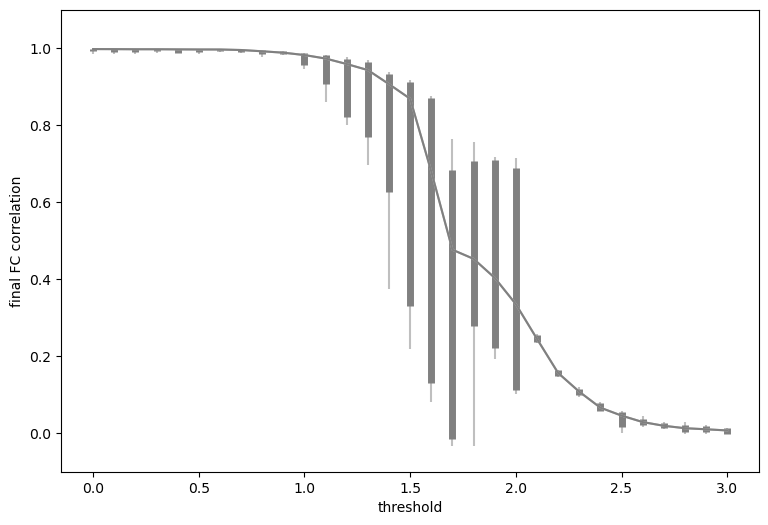

In [21]:
parameter_updates = stat_values.size(dim=0)-1
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
print_fitting_progress(axs, update_counts=thresholds, fc_corr=stat_values[parameter_updates,:,:], med_color=[0.0, 0.0, 0.0], ci_color=[0.5, 0.5, 0.5], range_color=[0.75, 0.75, 0.75], label=f'{parameter_updates} parameter updates')
axs.set_xlabel('threshold')
axs.set_ylabel(f'final {stat_name_label}')
axs.set_ylim([-0.1, 1.1])
# axs.set_title(f'{xname} vs {yname}')
plt.show()

In [19]:
print( torch.count_nonzero(stat_values[-1,:,:] < -1) )

tensor(1, device='cuda:0')
